In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from scipy.stats import randint as sp_randint
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostRegressor
from lmfit import Model
from xgboost import XGBRegressor
from collections import OrderedDict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import neighbors
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.feature_selection import mutual_info_regression,f_regression
from scipy.stats import spearmanr
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
import umap
from sklearn.metrics import make_scorer

pl.style.use('seaborn')
pl.rc('font',family='Arial')

In [2]:
def spear_r(y_true, y_pred):
    return spearmanr(y_true, y_pred)[0]

## Read in data

In [59]:
train_data = pd.read_csv("SubCh1_TrainingData.csv")
test_data = pd.read_csv("SubCh1_TestData.csv")

train_data['Timepoint'] = [1 if i == '24HR' else 0 for i in train_data['Timepoint']]
train_data['Treatment'] = [1 if i == 'DHA' else 0 for i in train_data['Treatment']]
train_data['BioRep'] = [int(i[-1]) for i in train_data['BioRep']]

test_data['Timepoint'] = [1 if i == '24HR' else 0 for i in test_data['Timepoint']]
test_data['Treatment'] = [1 if i == 'DHA' else 0 for i in test_data['Treatment']]
test_data['BioRep'] = [int(i[-1]) for i in test_data['BioRep']]

genes = list(train_data.drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis=1).columns)

## Split into four data frames and combine into one

Each new df corresponds to a particular timepoint/treatment combination:

- A: 6hr untreated
- B: 24hr untreated
- C: 6hr treated
- D: 24hr treated

In [95]:
X_A = train_data[(train_data['Timepoint'] == 0)&(train_data['Treatment'] == 0)].drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis = 1)
X_B = train_data[(train_data['Timepoint'] == 1)&(train_data['Treatment'] == 0)].drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis = 1)
X_C = train_data[(train_data['Timepoint'] == 0)&(train_data['Treatment'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis = 1)
X_D = train_data[(train_data['Timepoint'] == 1)&(train_data['Treatment'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis = 1)

Xt_A = test_data[(test_data['Timepoint'] == 0)&(test_data['Treatment'] == 0)].drop(['DHA_IC50','Sample_Names','Isolate','Timepoint','Treatment','BioRep'], axis = 1)
Xt_B = test_data[(test_data['Timepoint'] == 1)&(test_data['Treatment'] == 0)].drop(['DHA_IC50','Sample_Names','Isolate','Timepoint','Treatment','BioRep'], axis = 1)
Xt_C = test_data[(test_data['Timepoint'] == 0)&(test_data['Treatment'] == 1)].drop(['DHA_IC50','Sample_Names','Isolate','Timepoint','Treatment','BioRep'], axis = 1)
Xt_D = test_data[(test_data['Timepoint'] == 1)&(test_data['Treatment'] == 1)].drop(['DHA_IC50','Sample_Names','Isolate','Timepoint','Treatment','BioRep'], axis = 1)

Y = train_data[(train_data['Timepoint'] == 0)&(train_data['Treatment'] == 0)]['DHA_IC50']
bioreps = train_data[(train_data['Timepoint'] == 0)&(train_data['Treatment'] == 0)]['BioRep']
bioreps_test = test_data[(test_data['Timepoint'] == 0)&(test_data['Treatment'] == 0)]['BioRep']

# rename columns:
X_A.columns = ['A' + str(i) for i in range(1,5541)]
X_B.columns = ['B' + str(i) for i in range(1,5541)]
X_C.columns = ['C' + str(i) for i in range(1,5541)]
X_D.columns = ['D' + str(i) for i in range(1,5541)]

Xt_A.columns = ['A' + str(i) for i in range(1,5541)]
Xt_B.columns = ['B' + str(i) for i in range(1,5541)]
Xt_C.columns = ['C' + str(i) for i in range(1,5541)]
Xt_D.columns = ['D' + str(i) for i in range(1,5541)]

X_A = X_A.reset_index().drop(['index'],axis=1)
X_B = X_B.reset_index().drop(['index'],axis=1)
X_C = X_C.reset_index().drop(['index'],axis=1)
X_D = X_D.reset_index().drop(['index'],axis=1)

Xt_A = Xt_A.reset_index().drop(['index'],axis=1)
Xt_B = Xt_B.reset_index().drop(['index'],axis=1)
Xt_C = Xt_C.reset_index().drop(['index'],axis=1)
Xt_D = Xt_D.reset_index().drop(['index'],axis=1)

# combine data frames:
X = pd.concat([X_A,X_B,X_C,X_D], axis=1)
Xt = pd.concat([Xt_A,Xt_B,Xt_C,Xt_D], axis=1)
X.head(10)

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,D5531,D5532,D5533,D5534,D5535,D5536,D5537,D5538,D5539,D5540
0,1.311350,-1.613464,-1.298663,-1.441343,-1.735923,0.173112,2.466366,1.383979,-0.115130,0.287468,...,0.210607,-0.540993,-3.674097,-1.652979,-2.255490,-4.554757,-0.381422,-1.415857,-4.121011,-2.486528
1,0.997722,-1.553994,-1.960600,-1.424590,0.023609,0.420973,1.128427,0.722659,1.878123,-0.065159,...,-0.447109,0.450649,-4.464408,-0.977954,-2.012559,-4.538550,-2.333890,-2.342496,-4.774197,-1.794568
2,0.389508,-2.139782,-0.584985,-1.085373,0.803247,0.766617,1.701689,0.926101,1.600687,0.435633,...,-0.070151,0.024133,-2.215227,-1.957654,-2.188635,-4.424748,-2.986927,-1.722201,-3.995680,-0.902979
3,0.348560,-1.562540,-0.586732,-0.834661,1.096979,0.121817,1.623373,-0.654405,0.221121,0.998601,...,-1.288305,0.806314,-3.733712,-1.990368,-1.633418,-5.533077,-3.283316,-2.104227,-5.767710,-2.177930
4,0.138276,-1.612280,-1.362990,-1.360318,0.488124,0.365410,0.739845,-0.654702,2.170263,0.630418,...,0.279816,0.115002,-1.305902,-0.679212,-2.099512,-5.955507,-0.920594,-1.626372,-4.422711,-1.408485
5,-0.332565,-1.280348,-0.817751,-0.480521,-0.098970,0.112246,0.773993,-0.969944,1.117705,0.872166,...,0.375290,1.113241,-4.016287,-1.327287,-2.375500,-4.379304,-2.752906,-1.939162,-3.500963,-0.796143
6,-1.140942,-0.460872,0.588564,-1.214647,1.210955,1.336895,-0.857090,-1.884711,-0.001943,1.320737,...,0.666558,-2.016912,-4.682891,-0.254524,-2.668047,-6.573239,-3.264155,-0.671344,-5.312867,-2.248219
7,0.426584,-1.118851,-0.938263,-1.442067,0.747063,0.268388,1.062841,0.494635,0.866481,0.501923,...,-1.793459,-0.116719,-4.535173,-0.537190,-2.472669,-6.261742,-3.134708,-1.969545,-5.157691,-2.637917
8,0.037085,-1.488644,-1.838770,-1.066493,-1.305085,0.059484,2.128986,-0.527511,1.616871,0.235093,...,-0.478144,0.125283,-5.360958,-2.386122,-1.886257,-6.127057,-3.231487,-2.349583,-4.977880,-1.047555
9,-0.037537,-1.495531,-1.801568,-0.526676,-1.831555,0.494413,1.286978,-1.589983,1.060466,0.836018,...,1.213397,-1.032989,-8.298501,-0.080207,-2.335635,-4.606785,-2.849864,-2.028372,-3.179649,-2.205214


## Univariate f-regression, using top k features

In [5]:
def drop_univ(X_orig, Y, features):
    X = StandardScaler().fit_transform(X_orig)
    X_uni = GenericUnivariateSelect(f_regression,'k_best', param=features).fit_transform(X, Y.values.ravel())
    X_uni = pd.DataFrame(data = X_uni)

    return X_uni

### Test on reshaped data frame, testing different numbers of features

In [6]:
threshold = []
accuracy = []
mse = []
spearman = []
num_cols = []
cv = []
cv_spear = []

for j in np.arange(10,310,10):
    X_uni = drop_univ(X,Y,j)

    max_features = min(len(X_uni.columns),50)

    X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=10)

    svr_model = SVR()
    svr_model.fit(X_train, Y_train.values.ravel())
    Y_pred = svr_model.predict(X_test) 
    
    threshold.append(j)
    accuracy.append(svr_model.score(X_test,Y_test))
    mse.append(mean_squared_error(Y_test, Y_pred))
    spearman.append(spearmanr(Y_test,Y_pred)[0])
    num_cols.append(len(X_uni.columns))
    cv.append(np.mean(cross_val_score(svr_model, X_train, Y_train.values.ravel(), cv=5)))
    cv_spear.append(np.mean(cross_val_score(svr_model, X_train, Y_train.values.ravel(), cv=5,scoring=make_scorer(spear_r))))
    

results_unif = pd.DataFrame(list(zip(threshold,accuracy,mse,spearman,num_cols,cv,cv_spear)),columns =['threshold', 'accuracy','mse','spearman','num_cols','cv','cv_spear']) 

0.5861567679909726


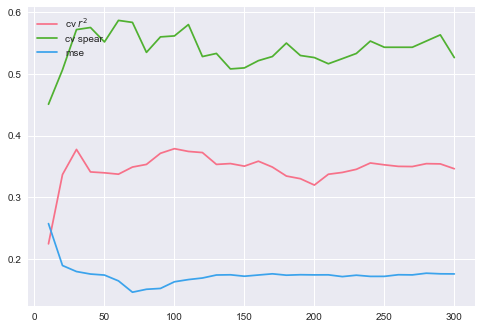

In [7]:
sns.set_palette("husl", 3)

print(np.max(results_unif['cv_spear']))

pl.plot(results_unif['threshold'],results_unif['cv'])
pl.plot(results_unif['threshold'],results_unif['cv_spear'])
pl.plot(results_unif['threshold'],results_unif['mse'])
pl.legend([r'cv $r^2$','cv spear','mse'])
pl.show()

## Test on only 24hr, treated data frame

In [8]:
threshold = []
accuracy = []
mse = []
spearman = []
num_cols = []
cv = []
cv_spear = []

for j in np.arange(10,310,10):
    X_uni = drop_univ(X_D,Y,j)

    max_features = min(len(X_uni.columns),50)

    X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=10)

    svr_model = SVR()
    svr_model.fit(X_train, Y_train.values.ravel())
    Y_pred = svr_model.predict(X_test) 
    
    threshold.append(j)
    accuracy.append(svr_model.score(X_test,Y_test))
    mse.append(mean_squared_error(Y_test, Y_pred))
    spearman.append(spearmanr(Y_test,Y_pred)[0])
    num_cols.append(len(X_uni.columns))
    cv.append(np.mean(cross_val_score(svr_model, X_train, Y_train.values.ravel(), cv=5)))
    cv_spear.append(np.mean(cross_val_score(svr_model, X_train, Y_train.values.ravel(), cv=5,scoring=make_scorer(spear_r))))
    

results_unif_sub = pd.DataFrame(list(zip(threshold,accuracy,mse,spearman,num_cols,cv,cv_spear)),columns =['threshold', 'accuracy','mse','spearman','num_cols','cv','cv_spear']) 

0.4962262949183172


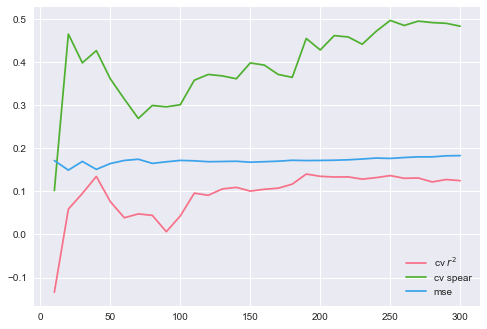

In [9]:
sns.set_palette("husl", 3)

print(np.max(results_unif_sub['cv_spear']))

pl.plot(results_unif_sub['threshold'],results_unif_sub['cv'])
pl.plot(results_unif_sub['threshold'],results_unif_sub['cv_spear'])
pl.plot(results_unif_sub['threshold'],results_unif_sub['mse'])
pl.legend([r'cv $r^2$','cv spear','mse'])
pl.show()

## Test on only 6hr, treated data frame

In [11]:
threshold = []
accuracy = []
mse = []
spearman = []
num_cols = []
cv = []
cv_spear = []

for j in np.arange(10,310,10):
    X_uni = drop_univ(X_C,Y,j)

    max_features = min(len(X_uni.columns),50)

    X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=10)

    svr_model = SVR()
    svr_model.fit(X_train, Y_train.values.ravel())
    Y_pred = svr_model.predict(X_test) 
    
    threshold.append(j)
    accuracy.append(svr_model.score(X_test,Y_test))
    mse.append(mean_squared_error(Y_test, Y_pred))
    spearman.append(spearmanr(Y_test,Y_pred)[0])
    num_cols.append(len(X_uni.columns))
    cv.append(np.mean(cross_val_score(svr_model, X_train, Y_train.values.ravel(), cv=5)))
    cv_spear.append(np.mean(cross_val_score(svr_model, X_train, Y_train.values.ravel(), cv=5,scoring=make_scorer(spear_r))))
    

results_unif_sub2 = pd.DataFrame(list(zip(threshold,accuracy,mse,spearman,num_cols,cv,cv_spear)),columns =['threshold', 'accuracy','mse','spearman','num_cols','cv','cv_spear']) 

0.5042525928408593


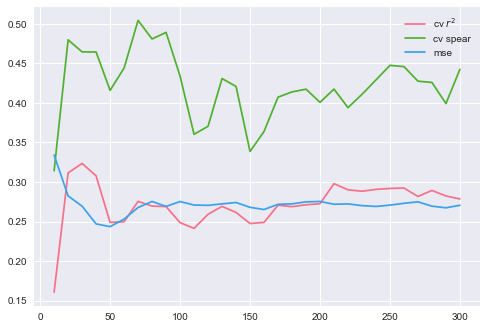

In [12]:
sns.set_palette("husl", 3)

print(np.max(results_unif_sub2['cv_spear']))

pl.plot(results_unif_sub2['threshold'],results_unif_sub2['cv'])
pl.plot(results_unif_sub2['threshold'],results_unif_sub2['cv_spear'])
pl.plot(results_unif_sub2['threshold'],results_unif_sub2['mse'])
pl.legend([r'cv $r^2$','cv spear','mse'])
pl.show()

In [10]:
X_s = StandardScaler().fit_transform(X)
transformer = GenericUnivariateSelect(f_regression,'k_best', param=70)
X_uni = transformer.fit_transform(X_s, Y.values.ravel())
X_uni = pd.DataFrame(data = X_uni)

indices = transformer.get_support(indices=False)

X_features = X.columns[indices].tolist()

In [11]:
print(X_features)

['A1040', 'A2793', 'B506', 'B1736', 'B2431', 'B4030', 'C44', 'C396', 'C419', 'C426', 'C511', 'C1103', 'C1315', 'C1531', 'C1559', 'C1702', 'C1751', 'C1786', 'C1820', 'C1904', 'C1949', 'C1970', 'C2035', 'C2097', 'C2260', 'C2287', 'C2567', 'C2681', 'C2711', 'C2714', 'C2718', 'C2905', 'C2931', 'C3078', 'C3238', 'C3257', 'C3291', 'C3357', 'C3361', 'C3436', 'C3531', 'C3577', 'C3702', 'C3985', 'C4292', 'C4607', 'C4743', 'C4792', 'C4861', 'C4982', 'C4987', 'C4988', 'C5019', 'C5058', 'C5240', 'C5245', 'C5444', 'D178', 'D960', 'D1103', 'D1107', 'D1181', 'D1901', 'D2061', 'D2241', 'D4447', 'D4866', 'D5025', 'D5183', 'D5520']


In [12]:
X_s = StandardScaler().fit_transform(X_D)
transformer = GenericUnivariateSelect(f_regression,'k_best', param=70)
X_uni = transformer.fit_transform(X_s, Y.values.ravel())
X_uni = pd.DataFrame(data = X_uni)

indices = transformer.get_support(indices=False)

X_D_features = X_D.columns[indices].tolist()

In [13]:
print(X_D_features)

['D2', 'D10', 'D14', 'D178', 'D206', 'D252', 'D292', 'D321', 'D410', 'D879', 'D960', 'D1035', 'D1056', 'D1103', 'D1107', 'D1108', 'D1110', 'D1181', 'D1314', 'D1367', 'D1459', 'D1505', 'D1553', 'D1603', 'D1626', 'D1901', 'D1910', 'D1914', 'D1985', 'D2061', 'D2229', 'D2233', 'D2236', 'D2241', 'D2279', 'D2342', 'D2619', 'D2643', 'D2753', 'D3069', 'D3169', 'D3349', 'D3398', 'D3432', 'D3463', 'D3464', 'D3564', 'D3638', 'D3647', 'D3924', 'D4062', 'D4161', 'D4193', 'D4227', 'D4447', 'D4591', 'D4640', 'D4754', 'D4785', 'D4815', 'D4866', 'D4995', 'D5025', 'D5029', 'D5033', 'D5182', 'D5183', 'D5481', 'D5485', 'D5520']


In [14]:
X_s = StandardScaler().fit_transform(X_C)
transformer = GenericUnivariateSelect(f_regression,'k_best', param=70)
X_uni = transformer.fit_transform(X_s, Y.values.ravel())
X_uni = pd.DataFrame(data = X_uni)

indices = transformer.get_support(indices=False)

X_C_features = X_C.columns[indices].tolist()

In [15]:
print(X_C_features)

['C44', 'C365', 'C396', 'C419', 'C426', 'C511', 'C563', 'C766', 'C1009', 'C1021', 'C1103', 'C1240', 'C1315', 'C1422', 'C1531', 'C1559', 'C1702', 'C1717', 'C1751', 'C1786', 'C1820', 'C1904', 'C1949', 'C1970', 'C2035', 'C2097', 'C2260', 'C2287', 'C2444', 'C2567', 'C2681', 'C2711', 'C2714', 'C2718', 'C2875', 'C2905', 'C2931', 'C3078', 'C3195', 'C3238', 'C3257', 'C3291', 'C3357', 'C3361', 'C3436', 'C3531', 'C3577', 'C3654', 'C3702', 'C3739', 'C3985', 'C4101', 'C4292', 'C4440', 'C4607', 'C4743', 'C4792', 'C4861', 'C4982', 'C4983', 'C4987', 'C4988', 'C5000', 'C5019', 'C5024', 'C5058', 'C5240', 'C5245', 'C5444', 'C5465']


In [16]:
list(set(X_features) & set(X_D_features))

['D1107',
 'D178',
 'D5183',
 'D1103',
 'D5025',
 'D1901',
 'D4866',
 'D2061',
 'D960',
 'D1181',
 'D4447',
 'D2241',
 'D5520']

### Conclusion: treated 24hr gives better Spearman score, but reshaped gives better cross-val score
- Weirdly, more features from the 6hr treated timepoint were used in the reshaped version

## Randomized search with SVR and reshaped data frame

In [17]:
X_s = StandardScaler().fit_transform(X)
transformer = GenericUnivariateSelect(f_regression,'k_best', param=70)
X_uni = transformer.fit_transform(X_s, Y.values.ravel())
X_uni = pd.DataFrame(data = X_uni)

In [24]:
X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=10)

svr_model = SVR()

param_dist = {"kernel": ['rbf', 'poly', 'sigmoid'],
              "C": [0.01,0.05,0.1, 0.5, 1, 5, 10, 50],
              "epsilon": [0.01, 0.05,  0.1, 0.015, 0.2,0.25],
              "gamma": [0.001, 0.01, 0.1, 'auto'],
              "degree": sp_randint(2,5)}

scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse': make_scorer(mean_squared_error)}

n_iter_search = 100
random_search = RandomizedSearchCV(svr_model, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False, 
                                   scoring = scoring, refit = 'r2', return_train_score=True)

random_search.fit(X_train, Y_train.values.ravel())
print(random_search.best_params_)

scores = pd.DataFrame(random_search.cv_results_)
condition = scores['rank_test_spear_r'] == 1
df_1 = scores[condition].reset_index(drop = True)
df_1.loc[0, 'mean_test_spear_r']

{'epsilon': 0.25, 'kernel': 'rbf', 'gamma': 0.001, 'degree': 3, 'C': 50}


0.7182028336446011

In [27]:
X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=10)

svr_model = SVR()

param_dist = {"kernel": ['rbf', 'poly', 'sigmoid'],
              "C": [0.01,0.05,0.1, 0.5, 1, 5, 10, 50],
              "epsilon": [0.01, 0.05,  0.1, 0.015, 0.2,0.25],
              "gamma": [0.001, 0.01, 0.1, 'auto'],
              "degree": sp_randint(2,5)}

scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse': make_scorer(mean_squared_error)}

n_iter_search = 100
random_search = RandomizedSearchCV(svr_model, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False, 
                                   scoring = scoring, refit = 'spear_r', return_train_score=True)

random_search.fit(X_train, Y_train.values.ravel())
print(random_search.best_params_)

scores = pd.DataFrame(random_search.cv_results_)
condition = scores['rank_test_spear_r'] == 1
df_1 = scores[condition].reset_index(drop = True)
df_1.loc[0, 'mean_test_spear_r']

{'epsilon': 0.25, 'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 50}


0.7082447625496696

In [28]:
scores[['param_kernel','param_C','param_epsilon','param_gamma','param_degree','rank_test_spear_r']].sort_values(by='rank_test_spear_r').head(10)

,param_kernel,param_C,param_epsilon,param_gamma,param_degree,rank_test_spear_r
74,rbf,50,0.25,0.1,3,1
80,rbf,10,0.2,0.1,3,2
1,poly,5,0.01,0.01,3,3
22,poly,1,0.01,0.01,3,4
6,poly,5,0.2,0.01,3,5
51,rbf,5,0.01,0.1,2,6
81,rbf,5,0.01,0.1,3,6
68,rbf,0.01,0.2,0.1,4,8
4,poly,10,0.015,0.01,3,9
44,poly,0.5,0.1,0.1,3,10


## Grid Search

In [26]:
X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=10)

svr_model = SVR()

param_grid = {"kernel": ['rbf', 'poly'],
              "C": np.arange(10,55,5),
              "epsilon": np.arange(0.15,0.35,0.05),
              "gamma": [0.001,0.1, 'auto'],
              "degree": [2,3,4]}

scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse': make_scorer(mean_squared_error)}

grid_search = GridSearchCV(svr_model, param_grid=param_grid, cv=5, iid=False, 
                                   scoring = scoring, refit = 'r2', return_train_score=True)

grid_search.fit(X_train, Y_train.values.ravel())
print(grid_search.best_params_)

grid_scores = pd.DataFrame(grid_search.cv_results_)
condition = grid_scores['rank_test_spear_r'] == 1
df_2 = grid_scores[condition].reset_index(drop = True)
df_2.loc[0, 'mean_test_spear_r']

{'epsilon': 0.25, 'kernel': 'rbf', 'gamma': 0.001, 'degree': 2, 'C': 15}


0.7215780958830031

In [51]:
X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=10)

svr_model = SVR()

param_grid = {"kernel": ['rbf', 'poly'],
              "C": np.arange(0.5,10.5,0.5),
              "epsilon": np.arange(0.05,0.55,0.05),
              "gamma": [0.1, 'auto'],
              "degree": [2,3,4]}

scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse': make_scorer(mean_squared_error)}

grid_search = GridSearchCV(svr_model, param_grid=param_grid, cv=5, iid=False, 
                                   scoring = scoring, refit = 'r2', return_train_score=True)

grid_search.fit(X_train, Y_train.values.ravel())
print(grid_search.best_params_)

grid_scores = pd.DataFrame(grid_search.cv_results_)
condition = grid_scores['rank_test_spear_r'] == 1
df_2 = grid_scores[condition].reset_index(drop = True)
df_2.loc[0, 'mean_test_spear_r']

{'kernel': 'poly', 'epsilon': 0.05, 'degree': 3, 'C': 3.0, 'gamma': 'auto'}


0.739967600358922

### refit: r2

In [38]:
X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=9)

#svr_model = SVR(kernel='poly',epsilon=0.05, degree=3,C=3,gamma='auto')
svr_model = SVR(kernel='rbf',epsilon=0.25, degree=2,C=15,gamma=0.001)
svr_model.fit(X_train, Y_train.values.ravel())
Y_pred = svr_model.predict(X_test) 

print('mse: ' + str(mean_squared_error(Y_test, Y_pred)))
print('accuracy: ' + str(svr_model.score(X_test,Y_test)))
print('spearman: ' + str(spearmanr(Y_test,Y_pred)[0]))
print('cv score: ' + str(np.mean(cross_val_score(svr_model, X_train, Y_train.values.ravel(), cv=5))))
print('cv spear: ' + str(np.mean(cross_val_score(svr_model, X_train, Y_train.values.ravel(), cv=5,scoring=make_scorer(spear_r)))))

mse: 0.14829980293118375
accuracy: 0.560615788049105
spearman: 0.48923122199610286
cv score: 0.2380171343475693
cv spear: 0.6909861738286928


### *testing. best params: (rbf, e=0.18, C = 20, gamma=0.001)
- mse: 0.145
- accuracy: 0.57
- spearman: 0.51
- cv: 0.27
- cv spear: 0.71

In [50]:
X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=10)

svr_model = SVR(kernel='rbf')

param_grid = {"C": np.arange(13,31,1),
              "epsilon": np.arange(0.1,0.3,0.01),
              "gamma": [0.001,0.01, 0.1, 'auto']}

scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse': make_scorer(mean_squared_error)}

grid_search = GridSearchCV(svr_model, param_grid=param_grid, cv=5, iid=False, 
                                   scoring = scoring, refit = 'r2', return_train_score=True)

grid_search.fit(X_train, Y_train.values.ravel())
print(grid_search.best_params_)

grid_scores = pd.DataFrame(grid_search.cv_results_)
condition = grid_scores['rank_test_spear_r'] == 1
df_2 = grid_scores[condition].reset_index(drop = True)
df_2.loc[0, 'mean_test_spear_r']

{'epsilon': 0.24999999999999992, 'gamma': 0.001, 'C': 13}


0.7216060484863822

In [58]:
X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=9)

svr_model = SVR(kernel='rbf',epsilon=0.18, C=20,gamma=0.001)
svr_model.fit(X_train, Y_train.values.ravel())
Y_pred = svr_model.predict(X_test) 

print('mse: ' + str(mean_squared_error(Y_test, Y_pred)))
print('accuracy: ' + str(svr_model.score(X_test,Y_test)))
print('spearman: ' + str(spearmanr(Y_test,Y_pred)[0]))
print('cv score: ' + str(np.mean(cross_val_score(svr_model, X_train, Y_train.values.ravel(), cv=5))))
print('cv spear: ' + str(np.mean(cross_val_score(svr_model, X_train, Y_train.values.ravel(), cv=5,scoring=make_scorer(spear_r)))))

mse: 0.1450967888945775
accuracy: 0.5701057116398662
spearman: 0.5139898870768772
cv score: 0.2684498948956698
cv spear: 0.7093963768213187


### refit: spear_r

In [90]:
X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=9)

svr_model = SVR(kernel='rbf',epsilon=0.35, degree=2,C=1,gamma=0.1)
svr_model.fit(X_train, Y_train.values.ravel())
Y_pred = svr_model.predict(X_test) 

print('mse: ' + str(mean_squared_error(Y_test, Y_pred)))
print('accuracy: ' + str(svr_model.score(X_test,Y_test)))
print('spearman: ' + str(spearmanr(Y_test,Y_pred)[0]))
print('cv score: ' + str(np.mean(cross_val_score(svr_model, X_train, Y_train.values.ravel(), cv=5))))
print('cv spear: ' + str(np.mean(cross_val_score(svr_model, X_train, Y_train.values.ravel(), cv=5,scoring=make_scorer(spear_r)))))

mse: 0.35689113676075956
train accuracy: 0.6470361023213123
accuracy: -0.05740080417134341
spearman: 0.37880757573584883
cv score: -0.05686595098027245
cv spear: 0.5671576183526388


## Drop by similarity/variance of bioreps

In [18]:
def drop_cosine(X_orig, Y, drop_point):
    reps1 = X_orig[(X_orig['BioRep'] == 1)]
    reps2 = X_orig[(X_orig['BioRep'] == 2)]
    names = []
    for i in range(len(X.columns)):
        if cosine_similarity(reps2.values[:,i].reshape(1, -1),reps1.values[:,i].reshape(1, -1))[0][0] < drop_point:
            names.append(X.columns[i])
    
    X_new = X_orig.drop(names,axis=1)
    X_new = X_new.drop('BioRep',axis=1)

    return X_new


In [19]:
def drop_biorep(X_orig, Y, drop_point):
    reps1 = X_orig[(X_orig['BioRep'] == 1)]
    reps2 = X_orig[(X_orig['BioRep'] == 2)]
    names = []
    for i in range(len(X.columns)):
        if np.mean(abs(reps2.values[:,i] - reps1.values[:,i]))/abs(np.max([reps1.values[:,i],reps2.values[:,i]])) > drop_point:
            names.append(X.columns[i])
    
    X_new = X_orig.drop(names,axis=1)
    X_new = X_new.drop('BioRep',axis=1)

    return X_new


In [20]:
X_new = drop_cosine(pd.concat([X,bioreps.reset_index().drop(['index'],axis=1)], axis=1),Y,0.75)

In [21]:
X_new2 = drop_biorep(pd.concat([X,bioreps.reset_index().drop(['index'],axis=1)], axis=1),Y,0.75)

In [84]:
list(set(X_new2.columns) & set(X_uni.columns))

[]

In [87]:
X_train, X_test , Y_train , Y_test = train_test_split(X_new,Y,test_size=0.33,random_state=9)

svr_model = SVR(kernel='poly',epsilon=0.05, degree=3,C=3,gamma='auto')
svr_model.fit(X_train, Y_train.values.ravel())
Y_pred = svr_model.predict(X_test) 

print('mse: ' + str(mean_squared_error(Y_test, Y_pred)))
print('accuracy: ' + str(svr_model.score(X_test,Y_test)))
print('spearman: ' + str(spearmanr(Y_test,Y_pred)[0]))
print('cv score: ' + str(np.mean(cross_val_score(svr_model, X_train, Y_train.values.ravel(), cv=5))))
print('cv spear: ' + str(np.mean(cross_val_score(svr_model, X_train, Y_train.values.ravel(), cv=5,scoring=make_scorer(spear_r)))))

mse: 0.517279049422515
accuracy: -0.5325997944494076
spearman: -0.31493021982745084
cv score: -0.31791450378591385
cv spear: 0.2048799261607896


In [85]:
X_train, X_test , Y_train , Y_test = train_test_split(X_new2,Y,test_size=0.33,random_state=9)

svr_model = SVR(kernel='poly',epsilon=0.05, degree=3,C=3,gamma='auto')
svr_model.fit(X_train, Y_train.values.ravel())
Y_pred = svr_model.predict(X_test) 

print('mse: ' + str(mean_squared_error(Y_test, Y_pred)))
print('accuracy: ' + str(svr_model.score(X_test,Y_test)))
print('spearman: ' + str(spearmanr(Y_test,Y_pred)[0]))
print('cv score: ' + str(np.mean(cross_val_score(svr_model, X_train, Y_train.values.ravel(), cv=5))))
print('cv spear: ' + str(np.mean(cross_val_score(svr_model, X_train, Y_train.values.ravel(), cv=5,scoring=make_scorer(spear_r)))))

mse: 0.40979757224087504
accuracy: -0.2141525462579359
spearman: -0.30849296690644945
cv score: 0.04041929010007348
cv spear: 0.46398017588759427


In [93]:
X_s = StandardScaler().fit_transform(X_new2)
transformer = GenericUnivariateSelect(f_regression,'k_best', param=70)
X_uni2 = transformer.fit_transform(X_s, Y.values.ravel())
X_uni2 = pd.DataFrame(data = X_uni2)

In [94]:
X_s = StandardScaler().fit_transform(X_new)
transformer = GenericUnivariateSelect(f_regression,'k_best', param=70)
X_uni3 = transformer.fit_transform(X_s, Y.values.ravel())
X_uni3 = pd.DataFrame(data = X_uni3)

In [95]:
X_train, X_test , Y_train , Y_test = train_test_split(X_uni2,Y,test_size=0.33,random_state=9)

svr_model = SVR(kernel='poly',epsilon=0.05, degree=3,C=3,gamma='auto')
svr_model.fit(X_train, Y_train.values.ravel())
Y_pred = svr_model.predict(X_test) 

print('mse: ' + str(mean_squared_error(Y_test, Y_pred)))
print('accuracy: ' + str(svr_model.score(X_test,Y_test)))
print('spearman: ' + str(spearmanr(Y_test,Y_pred)[0]))
print('cv score: ' + str(np.mean(cross_val_score(svr_model, X_train, Y_train.values.ravel(), cv=5))))
print('cv spear: ' + str(np.mean(cross_val_score(svr_model, X_train, Y_train.values.ravel(), cv=5,scoring=make_scorer(spear_r)))))

mse: 0.2440117704052146
accuracy: 0.27703936669430784
spearman: 0.6283749197500551
cv score: 0.08937293189932205
cv spear: 0.5848483073858267


In [96]:
X_train, X_test , Y_train , Y_test = train_test_split(X_uni3,Y,test_size=0.33,random_state=9)

svr_model = SVR(kernel='poly',epsilon=0.05, degree=3,C=3,gamma='auto')
svr_model.fit(X_train, Y_train.values.ravel())
Y_pred = svr_model.predict(X_test) 

print('mse: ' + str(mean_squared_error(Y_test, Y_pred)))
print('accuracy: ' + str(svr_model.score(X_test,Y_test)))
print('spearman: ' + str(spearmanr(Y_test,Y_pred)[0]))
print('cv score: ' + str(np.mean(cross_val_score(svr_model, X_train, Y_train.values.ravel(), cv=5))))
print('cv spear: ' + str(np.mean(cross_val_score(svr_model, X_train, Y_train.values.ravel(), cv=5,scoring=make_scorer(spear_r)))))

mse: 0.23984759752331453
accuracy: 0.2893770217955084
spearman: 0.3495923509405351
cv score: 0.19717615307648506
cv spear: 0.6837009750141804


## predict

In [122]:
X_s = StandardScaler().fit_transform(X)
transformer = GenericUnivariateSelect(f_regression,'k_best', param=70)
X_uni = transformer.fit_transform(X_s, Y.values.ravel())
X_uni = pd.DataFrame(data = X_uni)

indices = transformer.get_support(indices=False)

X_features = X.columns[indices].tolist()
X_uni.columns = X_features

Xs = StandardScaler().fit_transform(Xt)
X_predict = pd.DataFrame(data = Xs, columns = Xt.columns)
X_predict = X_predict[X_uni.columns]

bioreps_test = bioreps_test.reset_index().drop(['index'],axis=1)
X_bio = pd.concat([Xt,bioreps_test],axis=1)
X_bio1 = X_bio[X_bio['BioRep'] == 1].reset_index().drop(['index'],axis=1)
X_bio2 = X_bio[X_bio['BioRep'] == 2].reset_index().drop(['index'],axis=1)
X_avg = (X_bio1 + X_bio2)/2
X_avg = X_avg.drop(['BioRep'],axis=1)

Xs_avg = StandardScaler().fit_transform(X_avg)
X_predict_avg = pd.DataFrame(data = Xs_avg, columns = X_avg.columns)
X_predict_avg = X_predict_avg[X_uni.columns]

In [131]:
X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=9)

svr_model = SVR(kernel='rbf',epsilon=0.18, C=20,gamma=0.001)
#svr_model = SVR(kernel='rbf',epsilon=0.25, degree=2,C=15,gamma=0.001)
svr_model.fit(X_train, Y_train.values.ravel())
Y_pred = svr_model.predict(X_test) 
Y_pred_new = svr_model.predict(X_predict)
Y_pred_avg = svr_model.predict(X_predict_avg)

print('mse: ' + str(mean_squared_error(Y_test, Y_pred)))
print('accuracy: ' + str(svr_model.score(X_test,Y_test)))
print('spearman: ' + str(spearmanr(Y_test,Y_pred)[0]))
print('cv score: ' + str(np.mean(cross_val_score(svr_model, X_train, Y_train.values.ravel(), cv=5))))
print('cv spear: ' + str(np.mean(cross_val_score(svr_model, X_train, Y_train.values.ravel(), cv=5,scoring=make_scorer(spear_r)))))

mse: 0.1450967888945775
accuracy: 0.5701057116398662
spearman: 0.5139898870768772
cv score: 0.2684498948956698
cv spear: 0.7093963768213187


In [137]:
Y_pred

array([1.43920143, 2.04873828, 1.38770367, 1.46047323, 1.16817249,
       0.94936196, 1.26252647, 1.80824867, 1.79158498, 1.21420605,
       1.12167199, 2.8602533 , 1.52378014, 1.87013572, 1.15443468,
       1.3089647 , 1.22892027, 1.31470459, 1.7670493 , 1.80899627,
       1.7045321 , 1.53596082, 1.66078739])

In [132]:
predictions_avg = []
isolates = []
for i in range(int(len(Y_pred_avg))):
    isolates.append('isolate_'+str(i+31))
    predictions_avg.append(Y_pred_avg[i])

In [133]:
predictions = []
isolates = []
differences = []
for i in range(int(len(Y_pred_new)/2)):
    isolates.append('isolate_'+str(i+31))
    predictions.append((Y_pred_new[2*i]+Y_pred_new[2*i+1])/2.)
    differences.append(abs(Y_pred_new[2*i]-Y_pred_new[2*i+1]))

In [134]:
differences

[0.3821052576243229,
 0.2987150967218275,
 0.6414599867815562,
 0.6824842809019467,
 0.5716171319767818,
 0.5808736917806656,
 0.9202523600274573,
 0.3314446151459851,
 0.0853773323252609,
 0.048931031642146294,
 0.3239877020284929,
 0.36230921268241056,
 0.7411831589322353,
 0.3003439000413124,
 0.5661161627339384,
 0.5387793215573735,
 0.2217912282040384,
 0.25121286404509524,
 0.53769413260838,
 0.24706150148385042,
 0.1046228138402987,
 0.16180059496265864,
 0.9791412076248278,
 0.5091350373262702,
 1.043687822432671]

In [135]:
np.column_stack([predictions,predictions_avg])

array([[1.6374498 , 1.62413324],
       [1.60853704, 1.62617779],
       [1.57494897, 1.63338269],
       [1.83939231, 1.96310447],
       [1.46835782, 1.38282974],
       [1.33540586, 1.21645814],
       [1.78143368, 1.83803871],
       [1.67635969, 1.68409861],
       [1.65550199, 1.68150277],
       [1.31958691, 1.21928873],
       [1.3749343 , 1.21252732],
       [1.75092241, 1.84771938],
       [1.43587398, 1.42070721],
       [1.48378956, 1.46569724],
       [1.61195162, 1.66178233],
       [1.41157894, 1.35766118],
       [1.92124106, 2.09068938],
       [1.66693955, 1.71879233],
       [1.27303522, 1.16421382],
       [1.15424219, 1.00837035],
       [1.29007033, 1.15286086],
       [1.58650852, 1.63240393],
       [2.0081125 , 2.10746497],
       [1.72125915, 1.81731261],
       [1.79210908, 1.84252698]])

In [136]:
predict = pd.DataFrame(list(zip(isolates,predictions_avg)),columns=['Isolate','Predicted_IC50'])
predict.to_csv('SubCh1_Submission3.txt', index=None, header=True,sep='\t')
predict

,Isolate,Predicted_IC50
0,isolate_31,1.624133
1,isolate_32,1.626178
2,isolate_33,1.633383
3,isolate_34,1.963104
4,isolate_35,1.382830
5,isolate_36,1.216458
6,isolate_37,1.838039
7,isolate_38,1.684099
8,isolate_39,1.681503
9,isolate_40,1.219289


## next to do:
- try with different numbers of features
- test averaging with train data set